In [16]:
from biolearn.data_library import GeoData,DataLibrary
from biolearn.visualize import plot_sample_deviations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
import pandas as pd
# --- Reproducibility (safe; no model change) ---
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [2]:
#Load some evaluation data
evaluation_data = DataLibrary().get("GSE157131").load()

Eval DNAm shape: (445198, 946)
Eval metadata shape: (946, 5)

Eval metadata head:
                                  tissue  sex    age  \
id                                                    
GSM4753639  peripheral blood leukocytes    1  68.99   
GSM4753640  peripheral blood leukocytes    1  78.69   
GSM4753641  peripheral blood leukocytes    1  60.91   
GSM4753642  peripheral blood leukocytes    2  69.01   
GSM4753644  peripheral blood leukocytes    1  59.96   

           systolic_blood_pressure_(mmhg) diastolic_blood_pressure_(mmhg)  
id                                                                         
GSM4753639                            171                              82  
GSM4753640                            125                              60  
GSM4753641                            111                              74  
GSM4753642                            179                              74  
GSM4753644                            111                              72  

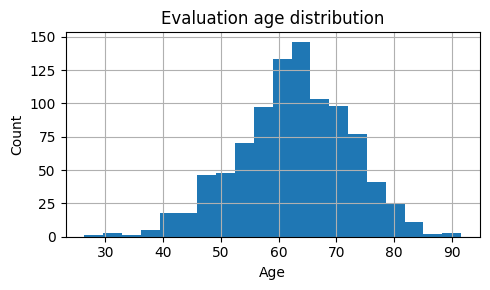

In [11]:
# === EDA A: Evaluation set sanity ===
ev = evaluation_data
print("Eval DNAm shape:", ev.dnam.shape)          # CpGs x samples
print("Eval metadata shape:", ev.metadata.shape)
print("\nEval metadata head:\n", ev.metadata.head())

# Missingness (should be ~0 for normalized arrays; any >0.5% warrants a peek)
ev_missing = ev.dnam.isna().mean().mean()
print(f"\nOverall missing rate (eval DNAm): {ev_missing:.4%}")

# Age summary
print("\nEvaluation age summary:")
print(ev.metadata['age'].describe())

# Histogram of eval ages
plt.figure(figsize=(5,3))
ev.metadata['age'].hist(bins=20)
plt.title("Evaluation age distribution")
plt.xlabel("Age"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


In [3]:
# Print the first few rows of the data to verify it loaded correctly
print(evaluation_data.dnam.head(10))

            GSM4753639  GSM4753640  GSM4753641  GSM4753642  GSM4753644  \
ID_REF                                                                   
cg00000029    0.743143    0.706606    0.628885    0.562915    0.614170   
cg00000109    0.956468    0.953614    0.962331    0.952262    0.952814   
cg00000165    0.151411    0.127816    0.092166    0.077027    0.120263   
cg00000236    0.904720    0.874442    0.863355    0.894204    0.876077   
cg00000289    0.864994    0.845839    0.883417    0.891442    0.873706   
cg00000292    0.937064    0.942809    0.942936    0.926290    0.939766   
cg00000321    0.377977    0.334562    0.254497    0.209236    0.436616   
cg00000363    0.377921    0.328329    0.403079    0.365630    0.373116   
cg00000622    0.014657    0.012975    0.017717    0.013984    0.014756   
cg00000658    0.916058    0.908628    0.920468    0.833336    0.915868   

            GSM4753645  GSM4753646  GSM4753649  GSM4753650  GSM4753653  ...  \
ID_REF                          

In [4]:
#Load some training data
train_data = DataLibrary().get("GSE40279").load()
train_data.metadata

,age,sex,ethnicity,tissue
id,,,,
GSM989827,67.0,1,Caucasian - European,whole blood
GSM989828,89.0,1,Caucasian - European,whole blood
GSM989829,66.0,1,Caucasian - European,whole blood
GSM989830,64.0,1,Caucasian - European,whole blood
GSM989831,62.0,1,Caucasian - European,whole blood
...,...,...,...,...
GSM990623,78.0,1,Caucasian - European,whole blood
GSM990624,71.0,2,Caucasian - European,whole blood
GSM990625,68.0,2,Caucasian - European,whole blood


In [5]:
train_data.dnam.head()

,GSM989827,GSM989828,GSM989829,GSM989830,GSM989831,GSM989832,GSM989833,GSM989834,GSM989835,GSM989836,...,GSM990618,GSM990619,GSM990620,GSM990621,GSM990622,GSM990623,GSM990624,GSM990625,GSM990626,GSM990627
id,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.464197,0.454883,0.485764,0.480785,0.501220,0.499918,0.485852,0.512442,0.518155,0.417986,...,0.560958,0.472081,0.508502,0.505193,0.443411,0.527496,0.588331,0.362994,0.499145,0.458600
cg00000108,0.941091,0.939033,0.918802,0.929908,0.934548,0.950543,0.925855,0.941330,0.938528,0.933814,...,0.934699,0.978612,0.922024,0.963052,0.992631,0.958173,0.982450,0.954392,0.931690,0.974731
cg00000109,0.911182,0.596455,0.870333,0.889689,0.890450,0.898493,0.893972,0.892010,0.900841,0.883539,...,0.881957,0.926289,0.930091,0.946547,0.929131,0.922034,0.855145,0.927184,0.900938,0.829869
cg00000165,0.132014,0.206917,0.162861,0.197780,0.148437,0.224093,0.400489,0.194553,0.134710,0.204569,...,0.199883,0.165116,0.210248,0.177351,0.118742,0.223068,0.162180,0.196430,0.167477,0.170578
cg00000236,0.717861,0.723935,0.719196,0.704061,0.754913,0.829192,0.723782,0.695142,0.731872,0.742913,...,0.759011,0.792883,0.730367,0.783830,0.787089,0.778959,0.796868,0.713020,0.730215,0.782844


Train DNAm shape: (473034, 656)
Train metadata shape: (656, 4)

Train metadata head:
             age  sex             ethnicity       tissue
id                                                     
GSM989827  67.0    1  Caucasian - European  whole blood
GSM989828  89.0    1  Caucasian - European  whole blood
GSM989829  66.0    1  Caucasian - European  whole blood
GSM989830  64.0    1  Caucasian - European  whole blood
GSM989831  62.0    1  Caucasian - European  whole blood

Age-bin counts (train):
age_bin
[0, 20)        1
[20, 40)      34
[40, 60)     212
[60, 80)     309
[80, 100)     99
Name: count, dtype: int64

sex counts (train):
sex
1    338
2    318
Name: count, dtype: int64

ethnicity counts (train):
ethnicity
Caucasian - European    426
Hispanic - Mexican      230
Name: count, dtype: int64

tissue counts (train):
tissue
whole blood    656
Name: count, dtype: int64


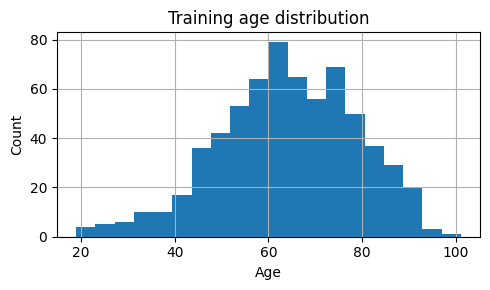

In [12]:
# === EDA B: Training set coverage ===
tr = train_data
print("Train DNAm shape:", tr.dnam.shape)         # CpGs x samples
print("Train metadata shape:", tr.metadata.shape)
print("\nTrain metadata head:\n", tr.metadata.head())

# Age distribution & stratification view
md = tr.metadata.copy()
bins = [0,20,40,60,80,100]
md['age_bin'] = pd.cut(md['age'], bins=bins, right=False, include_lowest=True)
print("\nAge-bin counts (train):")
print(md['age_bin'].value_counts().sort_index())

# Sex/Ethnicity balance (if available)
for col in [c for c in ['sex','ethnicity','tissue'] if c in md.columns]:
    print(f"\n{col} counts (train):")
    print(md[col].value_counts())

plt.figure(figsize=(5,3))
md['age'].hist(bins=20)
plt.title("Training age distribution")
plt.xlabel("Age"); plt.ylabel("Count")
plt.tight_layout(); plt.show()



Subset CpGs used for distribution: 20000
Global beta stats (train subset):
count    1.312000e+07
mean     5.175397e-01
std      3.687207e-01
min      0.000000e+00
1%       0.000000e+00
5%       1.187645e-02
50%      6.532567e-01
95%      9.519705e-01
99%      9.879863e-01
max      9.995062e-01
dtype: float64


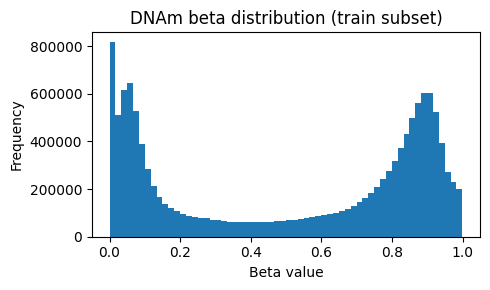


% CpGs with >1% missing (train): 0.0 %


In [14]:
# === EDA C (fixed): DNAm beta-value summaries, orientation-robust ===
def _which_axis_is_cpgs(df):
    # Heuristic: CpG ids often start with 'cg'. Fall back to longer axis.
    idx_cg = df.index.to_series().astype(str).str.startswith('cg').mean()
    col_cg = df.columns.to_series().astype(str).str.startswith('cg').mean()
    if idx_cg > col_cg:
        return 'index'
    if col_cg > idx_cg:
        return 'columns'
    # fallback: treat the longer dimension as CpGs
    return 'index' if df.shape[0] >= df.shape[1] else 'columns'

DF = tr.dnam  # training DNAm matrix

cpg_axis = _which_axis_is_cpgs(DF)
cap = 20000

if cpg_axis == 'index':
    # CpGs in rows, samples in columns
    subset = DF.iloc[:min(cap, DF.shape[0]), :]   # take first N CpGs
    beta_vals = subset.to_numpy().ravel(order='F')  # column-major flatten keeps CpGs grouped
    miss_per_cpg = DF.isna().mean(axis=1)
else:
    # CpGs in columns, samples in rows
    subset = DF.iloc[:, :min(cap, DF.shape[1])]   # take first N CpGs
    beta_vals = subset.to_numpy().ravel(order='C')  # row-major flatten keeps CpGs grouped
    miss_per_cpg = DF.isna().mean(axis=0)

print(f"\nSubset CpGs used for distribution: {subset.shape[0] if cpg_axis=='index' else subset.shape[1]}")
print("Global beta stats (train subset):")
print(pd.Series(beta_vals).describe(percentiles=[.01,.05,.5,.95,.99]))

plt.figure(figsize=(5,3))
plt.hist(beta_vals, bins=60)
plt.title("DNAm beta distribution (train subset)")
plt.xlabel("Beta value"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

print("\n% CpGs with >1% missing (train):", float((miss_per_cpg > 0.01).mean()*100), "%")


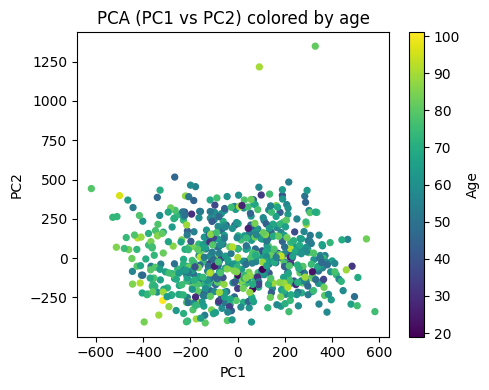

Explained variance ratio (PC1, PC2): [0.10616331 0.09112291]


In [17]:
# === EDA D: PCA structure + age coloring (train) ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_tr_df = tr.dnam.T   # samples x CpGs
sc_pca = StandardScaler(with_mean=False)  # memory-friendly for wide matrices
Xz = sc_pca.fit_transform(X_tr_df)
pca2 = PCA(n_components=2, random_state=SEED)
Z2 = pca2.fit_transform(Xz)

plt.figure(figsize=(5,4))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=md['age'], s=18)
plt.colorbar(sc, label="Age")
plt.title("PCA (PC1 vs PC2) colored by age")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

print("Explained variance ratio (PC1, PC2):", pca2.explained_variance_ratio_[:2])


In [18]:
# === EDA E: Top CpGs by correlation with age (train) ===
from scipy.stats import spearmanr

# Compute Spearman rho for a modest slice to keep runtime sane
k = 30000 if tr.dnam.shape[0] > 30000 else tr.dnam.shape[0]
slice_idx = tr.dnam.index[:k]
X_slice = tr.dnam.loc[slice_idx].T  # samples x CpGs
ages = md['age'].values

rhos = []
for c in X_slice.columns:
    r, _ = spearmanr(X_slice[c].values, ages)
    rhos.append(r)

top = pd.Series(rhos, index=X_slice.columns).abs().sort_values(ascending=False).head(20)
print("\nTop 20 |rho| CpGs (train slice):")
print(top)



Top 20 |rho| CpGs (train slice):
id
cg00292135    0.635955
cg01022345    0.607275
cg01486610    0.597505
cg01054110    0.583132
cg00636737    0.575784
cg00753885    0.563840
cg00439658    0.558851
cg00232105    0.552393
cg00417323    0.547201
cg00448560    0.539696
cg00103778    0.538729
cg00387658    0.538515
cg00533891    0.533507
cg01201215    0.528578
cg00748589    0.526546
cg00329615    0.522920
cg01314044    0.514660
cg00921350    0.513585
cg00684075    0.512124
cg00214171    0.511600
dtype: float64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
import pandas as pd

# Data
X = train_data.dnam.T
y = train_data.metadata['age']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return np.sqrt(mean_squared_error(y_true, y_pred))

results = {}

# --- 1) Ridge + feature selection ---
ridge_pipe = Pipeline([
    ("select", SelectKBest(score_func=f_regression, k=5000)),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=10.0))   # no random_state for old sklearn
])
ridge_pipe.fit(X_train, y_train)
y_pred = ridge_pipe.predict(X_test)
results["Ridge (5k CpGs)"] = rmse(y_test, y_pred)

# --- 2) PCR (PCA + OLS) ---
pcr_pipe = Pipeline([
    ("scale", StandardScaler(with_mean=False)),
    ("pca", PCA(n_components=50, random_state=42)),
    ("ols", LinearRegression())
])
pcr_pipe.fit(X_train, y_train)
y_pred = pcr_pipe.predict(X_test)
results["PCR (50 PCs)"] = rmse(y_test, y_pred)

# --- 3) PLS Regression ---
pls = PLSRegression(n_components=20)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)      # returns (n, 1)
results["PLS (20 comps)"] = rmse(y_test, y_pred)

# --- 4) Random Forest ---
rf = RandomForestRegressor(
    n_estimators=200, max_features="sqrt", n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results["Random Forest"] = rmse(y_test, y_pred)

# === Show results ===
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Test RMSE"])
print(results_df.sort_values("Test RMSE"))


                 Test RMSE
Ridge (5k CpGs)   4.393198
PLS (20 comps)    7.128907
PCR (50 PCs)      8.473382
Random Forest    10.172854



Per-model metrics:
                       MAE       RMSE        R2      Bias  CalibSlope  \
Ridge (5k CpGs)  3.270984   4.393198  0.924971  0.139485    0.889892   
PLS (20 comps)   5.712202   7.128907  0.802433  0.589808    0.702307   
PCR (50 PCs)     6.795242   8.473382  0.720885  0.824931    0.640960   
Random Forest    8.365985  10.172854  0.597695 -0.258561    0.418615   

                 CalibIntercept  
Ridge (5k CpGs)        7.254786  
PLS (20 comps)        19.827085  
PCR (50 PCs)          24.026522  
Random Forest         37.311234  


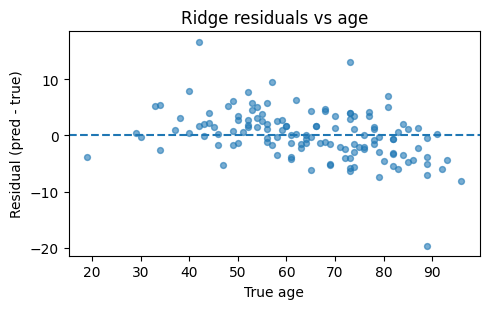


Ridge MAE by age bin:
 bin
[0, 20)      3.901139
[20, 40)     2.568466
[40, 60)     3.233585
[60, 80)     2.917477
[80, 100)    4.245541
Name: err, dtype: float64


/tmp/ipython-input-3054819127.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mae = pd.DataFrame({'bin':age_bins, 'err':np.abs(res)}).groupby('bin')['err'].mean()


In [19]:
# === Diagnostics F: Per-model metrics & residual analysis ===
from sklearn.metrics import mean_absolute_error, r2_score

def basic_report(name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    r2 = r2_score(y, yhat)
    bias = float(np.mean(yhat - y))
    slope, intercept = np.polyfit(y, yhat, 1)
    return pd.Series(dict(MAE=mae, RMSE=rmse(y,yhat), R2=r2, Bias=bias,
                          CalibSlope=slope, CalibIntercept=intercept), name=name)

# Recompute predictions (no model changes)
ridge_yhat = ridge_pipe.predict(X_test)
pcr_yhat   = pcr_pipe.predict(X_test)
pls_yhat   = pls.predict(X_test)
rf_yhat    = rf.predict(X_test)

rep = pd.concat([
    basic_report("Ridge (5k CpGs)", y_test, ridge_yhat),
    basic_report("PCR (50 PCs)",   y_test, pcr_yhat),
    basic_report("PLS (20 comps)", y_test, pls_yhat),
    basic_report("Random Forest",  y_test, rf_yhat),
], axis=1).T.sort_values("RMSE")
print("\nPer-model metrics:\n", rep)

# Residuals vs true age (for best model = Ridge here)
res = ridge_yhat - y_test.values
plt.figure(figsize=(5,3.2))
plt.scatter(y_test, res, s=18, alpha=0.6)
plt.axhline(0, ls="--")
plt.title("Ridge residuals vs age")
plt.xlabel("True age"); plt.ylabel("Residual (pred - true)")
plt.tight_layout(); plt.show()

# Optional: age-bin MAE to expose extremes
age_bins = pd.cut(y_test, bins=[0,20,40,60,80,100], right=False)
bin_mae = pd.DataFrame({'bin':age_bins, 'err':np.abs(res)}).groupby('bin')['err'].mean()
print("\nRidge MAE by age bin:\n", bin_mae)


In [7]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import copy

# --- data ---
X = train_data.dnam.T
y = train_data.metadata['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def rmse(a, b): return np.sqrt(mean_squared_error(np.asarray(a).ravel(), np.asarray(b).ravel()))

# --- base learners (same as before, but no parallelism) ---
ridge_cpg = Pipeline([
    ("select", SelectKBest(score_func=f_regression, k=10000)),   # if RAM tight, try 8000
    ("scale", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5))
])

pls_pipe = Pipeline([
    ("scale", StandardScaler(with_mean=False)),
    ("pca", PCA(n_components=30, random_state=42)),              # if RAM tight, try 20
    ("pls", PLSRegression(n_components=10))
])

# --- 1) Out-of-fold predictions (stacking features) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((len(X_train), 2))  # columns: [ridge, pls]

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]

    # fit clones to avoid leakage between folds
    r_model = copy.deepcopy(ridge_cpg)
    p_model = copy.deepcopy(pls_pipe)

    r_model.fit(X_tr, y_tr)
    p_model.fit(X_tr, y_tr)

    oof_preds[va_idx, 0] = r_model.predict(X_va).ravel()
    oof_preds[va_idx, 1] = p_model.predict(X_va).ravel()

# --- 2) Meta learner on OOF predictions ---
meta = Pipeline([
    ("scale", StandardScaler()),                 # normalize base predictions
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5))
])
meta.fit(oof_preds, y_train)
print("Meta alpha:", meta.named_steps["ridge"].alpha_)

# --- 3) Refit bases on full train and evaluate on test ---
ridge_cpg.fit(X_train, y_train)
pls_pipe.fit(X_train, y_train)

pred_ridge = ridge_cpg.predict(X_test)
pred_pls   = pls_pipe.predict(X_test)

# stacked test preds
stack_X_test = np.column_stack([pred_ridge.ravel(), pred_pls.ravel()])
pred_stack   = meta.predict(stack_X_test)

# --- metrics ---
results = pd.DataFrame({
    "Model": ["Ridge (CpGs)", "PLS (PCs)", "Stacked (Ridge+PLS)"],
    "Test RMSE": [
        rmse(y_test, pred_ridge),
        rmse(y_test, pred_pls),
        rmse(y_test, pred_stack)
    ]
}).sort_values("Test RMSE").reset_index(drop=True)

print(results)

# Optional: meta weights (after scaling, interpret as relative influence)
w = meta.named_steps["ridge"].coef_.ravel()
print("\nMeta weights [Ridge, PLS]:", w)


Meta alpha: 0.001
                 Model  Test RMSE
0  Stacked (Ridge+PLS)   4.264246
1         Ridge (CpGs)   4.333953
2            PLS (PCs)   9.435851

Meta weights [Ridge, PLS]: [15.80332049 -2.51806938]



Stacked metrics on test:
 MAE               3.163134
RMSE              4.264246
R2                0.929311
Bias             -0.229774
CalibSlope        0.872925
CalibIntercept    7.981954
Name: Stacked (Ridge+PLS), dtype: float64


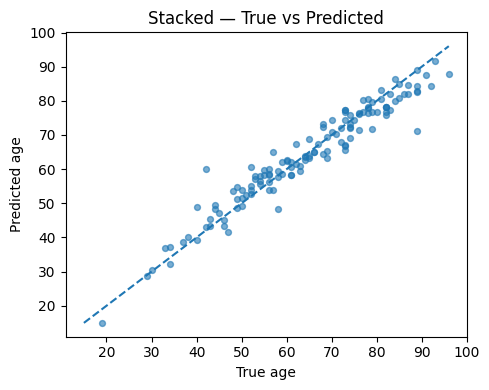

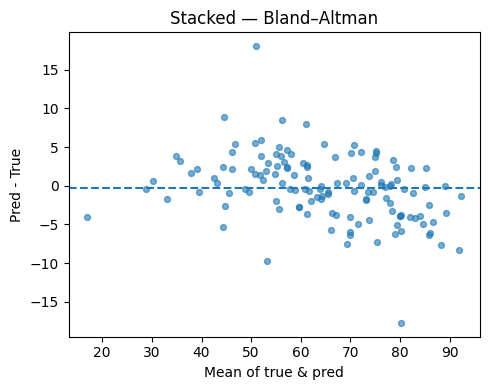


Stacked MAE by sex:
 sex
1    3.243184
2    3.047505
Name: abs_err, dtype: float64


In [20]:
# === Diagnostics G: Stacked model calibration & subgroup analysis ===
def diag_plots(y_true, y_pred, title):
    # True vs Predicted
    plt.figure(figsize=(5,4))
    plt.scatter(y_true, y_pred, s=18, alpha=0.6, label="Pred")
    lims = [float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))]
    plt.plot(lims, lims, ls="--")
    plt.title(title + " — True vs Predicted")
    plt.xlabel("True age"); plt.ylabel("Predicted age")
    plt.tight_layout(); plt.show()

    # Bland–Altman (agreement)
    mean_ = (y_true + y_pred)/2
    diff_ = y_pred - y_true
    plt.figure(figsize=(5,4))
    plt.scatter(mean_, diff_, s=18, alpha=0.6)
    plt.axhline(np.mean(diff_), ls="--", label="Mean bias")
    plt.title(title + " — Bland–Altman")
    plt.xlabel("Mean of true & pred"); plt.ylabel("Pred - True")
    plt.tight_layout(); plt.show()

# Metrics for stacked model on the held-out test set
stack_rep = basic_report("Stacked (Ridge+PLS)", y_test, pred_stack)
print("\nStacked metrics on test:\n", stack_rep)

diag_plots(y_test.values.ravel(), np.asarray(pred_stack).ravel(), "Stacked")

# Subgroup MAE by sex (if available in train/test split indices)
if 'sex' in tr.metadata.columns:
    # Map test indices back to metadata
    sex_test = tr.metadata.loc[X_test.index, 'sex']
    g = pd.DataFrame({'sex':sex_test, 'abs_err':np.abs(pred_stack - y_test.values)})
    print("\nStacked MAE by sex:\n", g.groupby('sex')['abs_err'].mean())


In [8]:
# --- Column aligner transformer ---
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnAligner(BaseEstimator, TransformerMixin):
    def __init__(self, columns, fill_values):
        self.columns = list(columns)
        # store as Series indexed by column for fast fillna after reindex
        self.fill_values = fill_values

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is a pandas DataFrame with CpGs as columns
        X = X.reindex(columns=self.columns)
        # fill NaNs for missing CpGs with training means
        X = X.fillna(self.fill_values)
        return X


                 Model      RMSE  Pearson r              p
0         Ridge (CpGs)  4.000601   0.943990   0.000000e+00
1  Stacked (Ridge+PLS)  4.000601   0.943990   0.000000e+00
2            PLS (PCs)  6.818413   0.719741  8.773719e-152


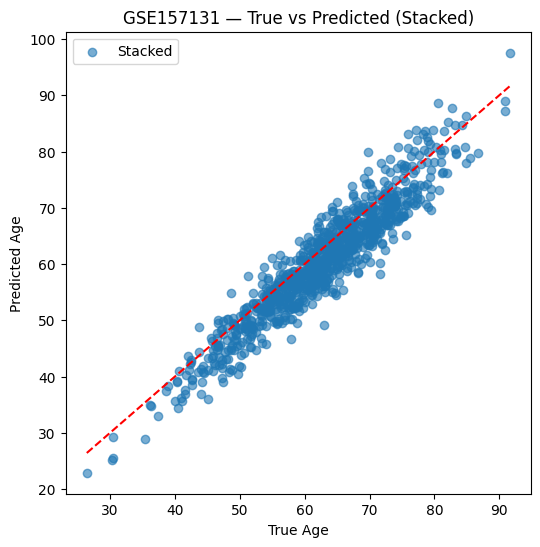

In [ ]:
# ===== FAST EVALUATION ON GSE157131 WITHOUT HEAVY REFITS =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

# 1) Align evaluation columns to training columns/order (cheap)
class ColumnAligner(BaseEstimator, TransformerMixin):
    def __init__(self, columns, fill_values):
        self.columns = list(columns)
        self.fill_values = fill_values
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.reindex(columns=self.columns)
        return X.fillna(self.fill_values)

X_train_all = train_data.dnam.T
y_train_all = train_data.metadata['age']
X_eval = evaluation_data.dnam.T
y_eval = evaluation_data.metadata['age']

aligner = ColumnAligner(X_train_all.columns, X_train_all.mean(axis=0))
X_eval_aligned = aligner.transform(X_eval)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 2) Use already-fitted models if available; else light fallback fits
from sklearn.exceptions import NotFittedError

def is_really_fitted(model, X_sample):
    try:
        # Try a 1-row predict; if it's not fitted, sklearn will raise
        _ = model.predict(X_sample.iloc[:1])
        return True
    except Exception:
        return False

X_train_all = train_data.dnam.T
y_train_all = train_data.metadata['age']
X_eval = evaluation_data.dnam.T
y_eval = evaluation_data.metadata['age']

aligner = ColumnAligner(X_train_all.columns, X_train_all.mean(axis=0))
X_eval_aligned = aligner.transform(X_eval)

use_prefit = (
    'ridge_cpg' in globals() and
    'pls_pipe'  in globals() and
    'meta'      in globals() and
    is_really_fitted(ridge_cpg, X_train_all) and
    is_really_fitted(pls_pipe,  X_train_all)
)

if not use_prefit:
    # ---- FAST FALLBACK (small CV, small dims) ----
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.linear_model import RidgeCV
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.pipeline import Pipeline
    import numpy as np

    ridge_cpg = Pipeline([
        ("select", SelectKBest(score_func=f_regression, k=8000)),
        ("scale", StandardScaler()),
        ("ridge", RidgeCV(alphas=[0.001,0.01,0.1,1,10,100], cv=3))
    ])
    pls_pipe = Pipeline([
        ("scale", StandardScaler(with_mean=False)),
        ("pca", PCA(n_components=20, random_state=42)),
        ("pls", PLSRegression(n_components=8))
    ])

    ridge_cpg.fit(X_train_all, y_train_all)
    pls_pipe.fit(X_train_all, y_train_all)

    # simple meta fit on train preds
    r_tr = ridge_cpg.predict(X_train_all).ravel()
    p_tr = pls_pipe.predict(X_train_all).ravel()
    A = np.column_stack([r_tr, p_tr])
    w, _, _, _ = np.linalg.lstsq(A, y_train_all.values.ravel(), rcond=None)
    class SimpleMeta:
        def __init__(self, w): self.w = w
        def predict(self, Z): return Z @ self.w
    meta = SimpleMeta(w)

use_prefit = False

if not use_prefit:
    # ---- FAST FALLBACK (small CV, small dims) ----
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.linear_model import RidgeCV
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.pipeline import Pipeline

    ridge_cpg = Pipeline([
        ("select", SelectKBest(score_func=f_regression, k=8000)),  # smaller k for speed
        ("scale", StandardScaler()),
        ("ridge", RidgeCV(alphas=[0.001,0.01,0.1,1,10,100], cv=3))
    ])
    pls_pipe = Pipeline([
        ("scale", StandardScaler(with_mean=False)),
        ("pca", PCA(n_components=20, random_state=42)),
        ("pls", PLSRegression(n_components=8))
    ])

    ridge_cpg.fit(X_train_all, y_train_all)
    pls_pipe.fit(X_train_all, y_train_all)

    # simple meta: learn optimal linear blend on train preds (no CV)
    r_tr = ridge_cpg.predict(X_train_all).ravel()
    p_tr = pls_pipe.predict(X_train_all).ravel()
    A = np.column_stack([r_tr, p_tr])
    w, _, _, _ = np.linalg.lstsq(A, y_train_all.values.ravel(), rcond=None)
    class SimpleMeta:
        def __init__(self, w): self.w = w
        def predict(self, Z): return Z @ self.w
    meta = SimpleMeta(w)

# 3) Predict on evaluation
pred_ridge_eval = ridge_cpg.predict(X_eval_aligned).ravel()
pred_pls_eval   = pls_pipe.predict(X_eval_aligned).ravel()
stack_X_eval    = np.column_stack([pred_ridge_eval, pred_pls_eval])
pred_stack_eval = meta.predict(stack_X_eval)

# 4) Metrics
def eval_row(name, y, yhat):
    r, p = pearsonr(y, yhat)
    return {"Model": name, "RMSE": rmse(y, yhat), "Pearson r": r, "p": p}

results = pd.DataFrame([
    eval_row("Ridge (CpGs)", y_eval, pred_ridge_eval),
    eval_row("PLS (PCs)",   y_eval, pred_pls_eval),
    eval_row("Stacked (Ridge+PLS)", y_eval, pred_stack_eval),
]).sort_values("RMSE").reset_index(drop=True)

print(results)

# 5) Quick scatter for the stacked model
plt.figure(figsize=(6,6))
plt.scatter(y_eval, pred_stack_eval, alpha=0.6, label="Stacked")
lims = [float(y_eval.min()), float(y_eval.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("True Age"); plt.ylabel("Predicted Age")
plt.title("GSE157131 — True vs Predicted (Stacked)")
plt.legend(); plt.show()
